In [116]:
# Import required packages
from pyomo.core.base import (ConcreteModel,Set,Var,Objective,Constraint,
                             Param, NonNegativeReals,PositiveReals, Reals)

In [117]:
# Using pyomo syntax:
# Create an "empty" model object:
m = ConcreteModel()
# Assuming that we are analysing 3 time snapshots, we also define the indices for each timestep, i.e., i=1,2,3 (i=0 is the initial condition)
m.TS = Set(initialize=[1,2,3])
m.dt = 0.5 # half-hour timestep

# Solar PV

In [118]:
# Forecasted solar PV generation (PV_f, kW) at time t can be modelled as a function of the insolation (Ins_PV), 
# installed capacity (depending on the available area) and efficiency of the solar panels (eta_PV):

                                            # PV_f(t)= eta_PV*Ins_PV(t)*Area

# The solar radiation data depends on the location of the building and inclination of the PV panels.

Ins_PV= [0.5,0.7,0.2] # Insolation (kW/m2)
Area = 50 # m2
eta_PV=0.18 # 18% defined as PV_max (kW)/[Area (m2)*1 (kW/m2)]

# We can also assume that solar PV output can be curtailed. In fact, there may be instances in which, because of 
# limits on power export to the grid along with low demand and battery storage reaching its full capacity, the only option
# would be to curtail any excess solar PV generation.

def Solar_PV(m):
    # Parameters
    m.PV_f=Param(m.TS,initialize={1:eta_PV*Area*Ins_PV[0],2:eta_PV*Area*Ins_PV[1],3:eta_PV*Area*Ins_PV[2]}) # PV forecasted power output: eta_PV*Ins_PV(t)*Area 
    # Decision variables
    m.PV_gen = Var(m.TS,initialize=0,domain=NonNegativeReals)  # Actual power output of the PV resulting from the optimization model
    m.PV_curt = Var(m.TS,initialize=0,domain=NonNegativeReals)  # PV curtailment resulting from the optimization model
    # Constraint
    def PV_power_rule(model,i):
        return model.PV_gen[i]  == model.PV_f[i] - model.PV_curt[i]   # actual production = forecasted production-curtailment

    m.con_PV = Constraint(m.TS, rule=PV_power_rule)
    return m
    # equality constraint to define the relationship between PV's actual power output and its curtailment
m=Solar_PV(m)
m.display()

Model unknown

  Variables:
    PV_gen : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    PV_curt : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals

  Objectives:
    None

  Constraints:
    con_PV : Size=3
        Key : Lower : Body : Upper
          1 :   0.0 : -4.5 :   0.0
          2 :   0.0 : -6.3 :   0.0
          3 :   0.0 : -1.8 :   0.0


In [119]:
print(m.con_PV[1].expr)

PV_gen[1]  ==  4.5 - PV_curt[1]


# Electric heat pump
The electric heat pump (EHP) heat output depends on its coefficient of performance (COP).
In fact, the $COP(T_{out})$ is itself a function of the outdoor temperature ($T_{out}(t)$), which in turn evolves with time.
We can therefore model the EHP with the following constraints:

1) $$EHP_{heat}^{output}(t)=EHP_{electricity}^{input}(t)*COP(t)$$

2) $$EHP_{heat}^{output}(t)\le EHP_{heat}^{max}(t)$$



In [120]:
def EHP(m):
    # Parameters
    EHP_heat_max = 3 # kWth is the maximum heat output
    # Assuming that COP(T_out) is a linear function (slope->m=4) of the outdoor temperature which, based on the forecasts at the analysed time
    # snapshots, will be:
    # T_out = [2,4,3]
    # m=4
    m.COP = Param(m.TS,initialize={1:1.5,2:2,3:1.75})
    # Decision variables
    # EHP electrical power input (kW) 
    m.ehp_E_input = Var(m.TS,initialize=0,domain=NonNegativeReals)
    # EHP heat power output (kW) 
    m.ehp_H_output = Var(m.TS,initialize=0,domain=NonNegativeReals)
    # Constraint
    def EHP_rule(model,i):
        return model.ehp_H_output[i]  == model.ehp_E_input[i]*m.COP[i]   
    m.con_EHP = Constraint(m.TS, rule=EHP_rule)
    def EHP_size(model,i):
        return model.ehp_H_output[i]<=EHP_heat_max
    m.size_EHP = Constraint(m.TS, rule=EHP_size)
    return m
m=EHP(m)
m.display()

Model unknown

  Variables:
    PV_gen : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    PV_curt : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    ehp_E_input : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    ehp_H_output : Size=3, Index=TS
        Key : Lowe

# Battery energy storage system (BESS)
A simple BESS model can be formulated considering:

1) Battery charging power (kW): $BESS_{ch}(t)\ge0$

2) Battery discharging power (kW): $BESS_{dis}(t)\ge0$

3) Battery state of charge (kWh): $SoC(t)\ge0$

Subject to the following constraints:

1) $$\frac{SoC(t)-SoC(t-1)}{dt} = \eta_{ch}*BESS_{ch}(t)-BESS_{dis}(t)/\eta_{dis}-BESS_{losses}$$

where $\eta_{ch}/\eta_{dis}$ are battery's charging/discharging efficiencies and $BESS_{losses}$ are battery self-consumption losses (typically very small values, assumed here to be zero for simplicity).

2) $$0\le BESS_{ch/dis}(t)\le BESS_{max}$$

to model limited charging/discharging rate power

3) $$SoC_{min}\le SoC(t)\le SoC_{max}$$

to model its limited storage capacity

In [121]:
def BESS(m):
    BESS_max=5 #kW-> max charge/discharge rate
    # eta_rt=0.9 # 90%  battery round-trip efficiency
    SoC_min=0
    SoC_max=13.5 # kWh
    
    # Battery-specific given parameters (round trip efficiency of 90%)
    eta_ch= 0.95 # charging efficiency
    eta_dis= 0.95 # discharging efficiency
    BESS_losses= 0 # Battery self-consumption losses (typically very small values, assumed here to be zero for simplicity)
    
    # Battery variables
    def BESS_ch_dis_rule(model,i):
        return (0,BESS_max)
    
    def SoC_rule(model,i):
        return (SoC_min,SoC_max)
    
    # Battery charging (consuming)
    m.BESS_ch = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) 
    # Battery discharging (generating)
    m.BESS_dis = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # if the battery is "generating" (discharging)
    # Battery net injection
    m.BESS_net = Var(m.TS,initialize=0,domain=Reals)
    m.SoC = Var(m.TS,initialize=0,bounds=SoC_rule)
    
    def BESS_net_inj_rule(model,i):
        return model.BESS_net[i]==model.BESS_dis[i]-model.BESS_ch[i]
    
    m.BESS_injection_con = Constraint(m.TS,rule=BESS_net_inj_rule)
    
    def BESS_rule(model,i):
        if i==1: # SoC at the start of the time horizon is equal to the SoC at the end
            i0=model.TS[-1]
        else:
            i0=i-1
        return model.SoC[i]-model.SoC[i0] == ((eta_ch*model.BESS_ch[i0])-(model.BESS_dis[i0]/eta_dis)-BESS_losses)*model.dt
    
    m.BESS_oper = Constraint(m.TS, rule=BESS_rule)
    return m

m=BESS(m)
m.display()

Model unknown

  Variables:
    PV_gen : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    PV_curt : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    ehp_E_input : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    ehp_H_output : Size=3, Index=TS
        Key : Lowe

In [122]:
print(m.BESS_oper[1].expr)
print(m.BESS_oper[2].expr)

SoC[1] - SoC[3]  ==  (0.95*BESS_ch[3] - 1.0526315789473684*BESS_dis[3])*0.5
SoC[2] - SoC[1]  ==  (0.95*BESS_ch[1] - 1.0526315789473684*BESS_dis[1])*0.5


It should be noted that both solar PV and BESS interface the grid through a power-electronics interface (PEI) which is typically 90-92% efficient. However, for the sake of simplicity, in these examples we are assuming a lossless PEI.

# Building model (space heating)

- The thermal characteristics of the building are given by the equivalent circuit (a capacitance and resistance);

For the sake of this example, we assume that:

- The building has $2$ occupants who are at home only at $t=2$

- The occupants require the house to be $21^\circ C$ when occupants are present and awake.

The temperature evolution depends on the heat transfers and building characteristics:

$$ T(i+1)=T(i)+\dfrac{1}{C_b}\left(H^{SH}(i)+[1-\alpha(i)]\left(Int(i)+Sol(i)\right)-\dfrac{(T(i)-T^{out}(i)) dt}{R_b} \right)$$

In [123]:
# Building C/R:
Cb = 23.16 #kWh/K This is building's material thermal capacitance, which reflects its thermal inertia and therefore its ability 
# to absorb, store and release heat.
Rb= 8.38 #K/kW This represents the building's material thermal resistance which reflects its ability to resist heat flow

In [124]:
# The internal (metabolic) heat gains (kW) is:
heat_gains = 0.12 # kW/occupant
Int_Heat_Gains_Data = 0.12*2 # heat gain for each occupant, where in this example the building has 2 occupants 
Occupancy = [0,1,0] # stores the information about whether occupants are at home (1) or not (0)
Int = [i*Int_Heat_Gains_Data for i in Occupancy] # [0,0.24,0]

In [125]:
def Building(m):
    m.TS_aux = Set(initialize=[1,2,3,4]) # auxiliary time set for temperature modelling
    # Parameters
    m.Temp_Out = Param(m.TS, initialize={1:2,2:2.5,3:5}) #C # prediction of outdoor temperature
    m.Sol = Param(m.TS, initialize={1:0,2:0,3:0}) # kWh solar gain, that is the heat increase of a structure resulting from 
    # absorbed solar radiation which depends on the building structure. For buildings with double glazed windows, typical values
    # for the Solar Heat Gain Coefficient (SHGC) are in the range of 0.42 - 0.55. However, in this example we assume it to be zero.
    m.Int = Param(m.TS, initialize={1:0,2:0.24,3:0}) # heat coming from the presence of occupants in the building (metabolic gain)

    # Variables
    # Inside temperature of the building
    m.temp = Var(m.TS_aux, initialize=21)
    # Heat delivered to the building for space heating (kWh)
    m.h_sh = Var(m.TS, initialize=0, domain=NonNegativeReals)
    # Alpha is the ventilation variable which depends on the exchange between the outside and inside of the building and affects
    # the internal and solar gains.In this example we consider a variation of ventilation factor (in p.u.) that can range 
    # between 0 and 1 to avoid infeasibilities. 
    m.alpha = Var(m.TS,initialize=0,bounds=(0,1))
    
    # To accommodate the occupant preferences to keep temperature at 21°C (at t=2) we also define:
    m.temp_pref = Constraint(rule=lambda m: m.temp[2] == 21)
    
    # The following constraint models the temperature evolution depending on the heat transfers and building characteristics.
    m.building_system = Constraint(m.TS, rule=lambda m, i: m.temp[i+1] == m.temp[i]+
                              (m.h_sh[i] + (1-m.alpha[i])*(m.Int[i]+m.Sol[i])-
                               (m.temp[i]-m.Temp_Out[i])*m.dt*(1/Rb))*(1/Cb))
    return m
m=Building(m)
m.display()

Model unknown

  Variables:
    PV_gen : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    PV_curt : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    ehp_E_input : Size=3, Index=TS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :  None : False : False : NonNegativeReals
          2 :     0 :     0 :  None : False : False : NonNegativeReals
          3 :     0 :     0 :  None : False : False : NonNegativeReals
    ehp_H_output : Size=3, Index=TS
        Key : Lowe

# Unidirectional pricing

In [126]:
### Import required packages ###
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import numpy as np
from pyomo.core.base import (ConcreteModel,Set,Var,Objective,Constraint,
                             Param, NonNegativeReals,PositiveReals, Reals)
import os
import pandas as pd
import json
from pyomo.environ import *

### PYOMO MODEL ###

# Create the model object:
m = ConcreteModel()

# Indices for each timestep, here i= 1 to 48
m.TS = Set(initialize=[i+1 for i in range(48)])

# Time step between data in hours (30 minutes = 0.5 hours)
m.dt = 0.5 

### READ DATA ###

# Outside temperature data
#http://www.bom.gov.au/products/IDV60901/IDV60901.95936.shtml#other_formats
mydir = os.getcwd()
loc = mydir + '/data/outdoor_temp_data/temp.json'
f = open(loc)
data = json.load(f)
weather = data['observations']['data'] #This gives all kind of information as a dict at every time point
temp = [] # Temperature array
for t in weather[0:48]: #can choose how many data point here up to 72.
    temp.append(t['air_temp']) 
T_out = np.array(temp) # Numpy array of outside temps and convert to kW

# Load usage data
#https://github.com/utwente-energy/alpg
filename = mydir + '/data/load_data/load_profile.csv'
load_profile_min = np.loadtxt(filename, delimiter=',') #This give the load profile every 1 minute
load_values = load_profile_min[::30]/1000 #extract the 30th index at each stage #### NEED TO GET RID OF /1000 ONCE DATA IS GIVEN IN KW
m.P_Load =  Param(m.TS,initialize={i: load_values[i-1] for i in m.TS}) # Set as parameter of model

# Insolation (kW/m2) data
#http://www.bom.gov.au/climate/data/oneminsolar/about-IDCJAC0022.shtml
my_file = open(mydir + '/data/solar_data/sol.txt', 'r')
data = my_file.read()
idx_data_start = 2249
idx_entry_len = 253
idx_sol_start = 30
idx_sol_end = 34
Ins_PV = []
for i in range(0,48): #
    Ins_PV.append(float(data[idx_data_start+30*i*idx_entry_len+idx_sol_start:idx_data_start+i*30*idx_entry_len+idx_sol_end])/1000) #### NEED TO GET RID OF /1000 ONCE DATA IS GIVEN IN KW

# Tariff (assuming same price for export and import and constant)
m.import_tariff = Param(m.TS, initialize=0.25) # 25c per kwh
    
### INPUTS ###

# Minimum and maximum temperature of the house (comfort constraint)
temp_min = 20 # Degrees
temp_max = 21 # Degrees
temp_initial = 21 # Degrees

# Area of panels
Area = 50 # m2

# Panel efficency 
eta_PV=0.18 # 18% defined as PV_max (kW)/[Area (m2)*1 (kW/m2)]

# Heat pump max output
EHP_heat_max = 3 # kWth 

# Battery max charge/discharge rate in kw
BESS_max=5 

# Battery minimum SOC 
SoC_min=0

# Battery maximum SOC 
SoC_max=13.5 # kWh

# Battery charging efficency
eta_ch= 0.95 

# Battery discharging efficiency
eta_dis= 0.95 

# Battery self-consumption losses (typically very small values, assumed here to be zero for simplicity)
BESS_losses= 0 

# Building thermal capacitance which reflects its thermal inertia and therefore its ability to absorb, store and release heat
Cb = 23.16 # kWh/K 

# Building material thermal resistance which reflects its ability to resist heat flow
Rb= 8.38 # K/kW 

# Absorbed solar radiation which depends on the building structure
SHGC = 0 # For buildings with double glazed windows, typical valuesfor the Solar Heat Gain Coefficient (SHGC) are in the range of 0.42 - 0.55. However, in this example we assume it to be zero.

# Heat gain per occupant
heat_gains = 0.12 # kW/occupant

# Number of occupants
occupants = 2

# Occupants home or not at throughout the day. Assume always home
Occupancy = np.ones(48) # home (1) or not (0)

# Export limit in kW
export_lim = 5

### PV MODEL ###

# Parameters
m.PV_f=Param(m.TS,initialize={i: eta_PV*Area*Ins_PV[i-1] for i in m.TS}) # PV forecasted power output: eta_PV*Ins_PV(t)*Area 

# Decision variables
m.PV_gen = Var(m.TS,initialize=0,domain=NonNegativeReals)  # Actual power output of the PV resulting from the optimization model
m.PV_curt = Var(m.TS,initialize=0,domain=NonNegativeReals)  # PV curtailment resulting from the optimization model

# Constraints
# Curtailment constraint (actual production = forecasted production-curtailment)
def PV_power_rule(model,i):
    return model.PV_gen[i]  == model.PV_f[i] - model.PV_curt[i]  
m.con_PV = Constraint(m.TS, rule=PV_power_rule) 

### EHP MODEL ###

# Parameters
COP_T = 0.25* T_out + 1 # COP(T_out) as a linear function of the outdoor temperature with slope=4
m.COP = Param(m.TS,initialize={i: COP_T[i-1] for i in m.TS}) # Store COP vector as time series parameter

# Decision variables
m.ehp_E_input = Var(m.TS,initialize=0,domain=NonNegativeReals) # EHP electrical power input (kW) 
m.ehp_H_output = Var(m.TS,initialize=0,domain=NonNegativeReals) # EHP heat power output (kW) 

# Constraints
# The heat output is equal to the electric power input times the COP value
def EHP_rule(model,i):
    return model.ehp_H_output[i]  == model.ehp_E_input[i]*m.COP[i]   
m.con_EHP = Constraint(m.TS, rule=EHP_rule)
# The heat output must be less than the max heat output
def EHP_size(model,i):
    return model.ehp_H_output[i]<=EHP_heat_max
m.size_EHP = Constraint(m.TS, rule=EHP_size)

### BESS MODEL ###
    
# Bounds definitions for variables
# Discharge cannot be greater than limit
def BESS_ch_dis_rule(model,i):
    return (0,BESS_max)
# SOC cannot be less than minimum value and more than maximum value
def SoC_rule(model,i):
    return (SoC_min,SoC_max)

# Decision variables
m.BESS_ch = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery charging (consuming) power
m.BESS_dis = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery discharging (generating) power 
m.BESS_net = Var(m.TS,initialize=0,domain=Reals) # Battery net injection of power
m.SoC = Var(m.TS,initialize=4,bounds=SoC_rule) # Battery SOC

# Constraints
# Battery net injection is equal to the difference between the charging and discharging powers
def BESS_net_inj_rule(model,i):
    return model.BESS_net[i]==model.BESS_dis[i]-model.BESS_ch[i] # Postive power implies discharging/generating
m.BESS_injection_con = Constraint(m.TS,rule=BESS_net_inj_rule)
# SOC at each time step is based in previous discharge and charge values
def BESS_rule(model,i):
    if i==1: # SoC at the start of the time horizon is equal to the SoC at the end
        i0=model.TS[-1]
    else:
        i0=i-1
    return model.SoC[i]-model.SoC[i0] == ((eta_ch*model.BESS_ch[i0])-(model.BESS_dis[i0]/eta_dis)-BESS_losses)*model.dt
m.BESS_oper = Constraint(m.TS, rule=BESS_rule)

### BUILDING MODEL ###

# Parameters
m.TS_aux = Set(initialize=[i+1 for i in range(49)]) # Auxiliary time set for temperature modelling
m.Temp_Out = Param(m.TS, initialize={i: T_out[i-1] for i in m.TS}) # Prediction of outdoor temperature 
m.Sol = Param(m.TS, initialize={i: SHGC*Ins_PV[i-1] for i in m.TS}) # The kWh solar gain, that is the heat increase of a structure resulting from solar radiation 
Int_Heat_Gains_Data = heat_gains*occupants # Heat gain due to occupants 
Int = [i*Int_Heat_Gains_Data for i in Occupancy] # Heat gain at each time step
m.Int = Param(m.TS, initialize={i: Int[i-1] for i in m.TS}) # Heat coming from the presence of occupants in the building (metabolic gain)

# Variables
m.temp = Var(m.TS_aux, initialize=21, bounds=(temp_min,temp_max)) # Inside temperature of the building
m.h_sh = Var(m.TS, initialize=0, domain=NonNegativeReals) # Heat delivered to the building for space heating (kWh)
m.alpha = Var(m.TS,initialize=0,bounds=(0,1)) # Alpha (ventilation variable)

# Constraints
# Accommodate the occupant preferences to keep temperature at inital preference at t=2
m.temp_pref = Constraint(rule=lambda m: m.temp[2] == temp_initial)
# Temperature evolution depends on the heat transfers and building characteristics.
m.building_system = Constraint(m.TS, rule=lambda m, i: m.temp[i+1] == m.temp[i]+
                          (m.h_sh[i] + (1-m.alpha[i])*(m.Int[i]+m.Sol[i])-
                           (m.temp[i]-m.Temp_Out[i])*m.dt*(1/Rb))*(1/Cb))
# The heat energy from the pump is equal to the output heat power of the pump multiplied by the time step length (joins heat pump and building model)
m.heat_energy = Constraint(m.TS, rule=lambda m, i: m.h_sh[i] == m.dt * m.ehp_H_output[i])

### POWER FLOW MODEL ###

# Variables
m.P_net = Var(m.TS,initialize=0,bounds=(-export_lim,None)) # Net power flow (postive is drawing power, negative inejcting power)

# Constraints
# Net power flowing in or out is equal to the difference between the consumed and generated power
def Power_flow(model,i):
    return model.P_net[i] == model.P_Load[i]+model.ehp_E_input[i] - m.BESS_net[i] -model.PV_gen[i]
m.Power_flow_in_con = Constraint(m.TS,rule=Power_flow)

### OBJECTIVE FUNCTION ###

# Define the objective function (minimize the total cost), where the cost is equal to the energy (net power flow multiplied by the time step) multiplied by the tariff 
m.objective = pyo.Objective(expr=sum(m.import_tariff[i]*m.P_net[i]*m.dt for i in m.TS),sense=minimize)

### USE MODEL ###
solver = pyo.SolverFactory('ipopt')
results = solver.solve(m)

### RESULTS  ###
print(f"Total cost: {pyo.value(m.objective):.2f}")
m.display()

Total cost: 0.89
Model unknown

  Variables:
    PV_gen : Size=48, Index=TS
        Key : Lower : Value                 : Upper : Fixed : Stale : Domain
          1 :     0 : 5.602320550131999e-10 :  None : False : False : NonNegativeReals
          2 :     0 : 5.619926920680866e-10 :  None : False : False : NonNegativeReals
          3 :     0 : 5.382922774993056e-10 :  None : False : False : NonNegativeReals
          4 :     0 : 5.366642345580939e-10 :  None : False : False : NonNegativeReals
          5 :     0 : 5.376794551873686e-10 :  None : False : False : NonNegativeReals
          6 :     0 : 5.380295374618156e-10 :  None : False : False : NonNegativeReals
          7 :     0 : 5.632423117873878e-10 :  None : False : False : NonNegativeReals
          8 :     0 : 5.380559490610809e-10 :  None : False : False : NonNegativeReals
          9 :     0 : 5.629938601658507e-10 :  None : False : False : NonNegativeReals
         10 :     0 : 5.377997666968418e-10 :  None : False : Fa

In [127]:
#Test Bench
def Test (m):
    Temperature = m.temp.extract_values()
    for i in Temperature:
        if (Temperature[i] < temp_min or Temperature[i] > temp_max):
            print('Temperature out of bounds')
            print(Temperature[i])

    Net_Power = m.P_net.extract_values()
    for i in Net_Power:
        if(Net_Power[i] < -5 or Net_Power[i] > 5):
            print('Net Power is out of bounds.')
            print(Net_Power[i])

    EHP_Power = m.ehp_H_output.extract_values()
    for i in EHP_Power:
        if(EHP_Power[i] < 0 or EHP_Power[i] > EHP_heat_max):
            print('EHP Power is out of bounds')
            print(EHP_Power[i])

    
    
Test(m)

Temperature out of bounds
21.000000207960582


# Bidirectional pricing

In [128]:
### Import required packages ###
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import numpy as np
from pyomo.core.base import (ConcreteModel,Set,Var,Objective,Constraint,
                             Param, NonNegativeReals,PositiveReals, Reals)
import os
import pandas as pd
import json
from pyomo.environ import *

### PYOMO MODEL ###

# Create the model object:
m = ConcreteModel()

# Indices for each timestep, here i= 1 to 48
m.TS = Set(initialize=[i+1 for i in range(48)])

# Time step between data in hours (30 minutes = 0.5 hours)
m.dt = 0.5 

### READ DATA ###

# Outside temperature data
#http://www.bom.gov.au/products/IDV60901/IDV60901.95936.shtml#other_formats
mydir = os.getcwd()
loc = mydir + '/data/outdoor_temp_data/temp.json'
f = open(loc)
data = json.load(f)
weather = data['observations']['data'] #This gives all kind of information as a dict at every time point
temp = [] # Temperature array
for t in weather[0:48]: #can choose how many data point here up to 72.
    temp.append(t['air_temp']) 
T_out = np.array(temp) # Numpy array of outside temps and convert to kW

# Load usage data
#https://github.com/utwente-energy/alpg
filename = mydir + '/data/load_data/load_profile.csv'
load_profile_min = np.loadtxt(filename, delimiter=',') #This give the load profile every 1 minute
load_values = load_profile_min[::30]/1000 #extract the 30th index at each stage #### NEED TO GET RID OF /1000 ONCE DATA IS GIVEN IN KW
m.P_Load =  Param(m.TS,initialize={i: load_values[i-1] for i in m.TS}) # Set as parameter of model

# Insolation (kW/m2) data
#http://www.bom.gov.au/climate/data/oneminsolar/about-IDCJAC0022.shtml
my_file = open(mydir + '/data/solar_data/sol.txt', 'r')
data = my_file.read()
idx_data_start = 2249
idx_entry_len = 253
idx_sol_start = 30
idx_sol_end = 34
Ins_PV = []
for i in range(0,48): #
    Ins_PV.append(float(data[idx_data_start+30*i*idx_entry_len+idx_sol_start:idx_data_start+i*30*idx_entry_len+idx_sol_end])/1000) #### NEED TO GET RID OF /1000 ONCE DATA IS GIVEN IN KW

# Tariff (assuming same price for export and import and constant)
m.import_tariff = Param(m.TS, initialize=0.25) # 25c per kwh
m.export_tariff = Param(m.TS, initialize=0.25) # 5c per kwh
    
### INPUTS ###

# Minimum and maximum temperature of the house (comfort constraint)
temp_min = 20 # Degrees
temp_max = 21 # Degrees
temp_initial = 21 # Degrees

# Area of panels
Area = 50 # m2

# Panel efficency 
eta_PV=0.18 # 18% defined as PV_max (kW)/[Area (m2)*1 (kW/m2)]

# Heat pump max output
EHP_heat_max = 3 # kWth 

# Battery max charge/discharge rate in kw
BESS_max=5 

# Battery minimum SOC 
SoC_min=0

# Battery maximum SOC 
SoC_max=13.5 # kWh

# Battery charging efficency
eta_ch= 0.95 

# Battery discharging efficiency
eta_dis= 0.95 

# Battery self-consumption losses (typically very small values, assumed here to be zero for simplicity)
BESS_losses= 0 

# Building thermal capacitance which reflects its thermal inertia and therefore its ability to absorb, store and release heat
Cb = 23.16 # kWh/K 

# Building material thermal resistance which reflects its ability to resist heat flow
Rb= 8.38 # K/kW 

# Absorbed solar radiation which depends on the building structure
SHGC = 0 # For buildings with double glazed windows, typical valuesfor the Solar Heat Gain Coefficient (SHGC) are in the range of 0.42 - 0.55. However, in this example we assume it to be zero.

# Heat gain per occupant
heat_gains = 0.12 # kW/occupant

# Number of occupants
occupants = 2

# Occupants home or not at throughout the day. Assume always home
Occupancy = np.ones(48) # home (1) or not (0)

# Export limit in kW
export_lim = 5

### PV MODEL ###

# Parameters
m.PV_f=Param(m.TS,initialize={i: eta_PV*Area*Ins_PV[i-1] for i in m.TS}) # PV forecasted power output: eta_PV*Ins_PV(t)*Area 

# Decision variables
m.PV_gen = Var(m.TS,initialize=0,domain=NonNegativeReals)  # Actual power output of the PV resulting from the optimization model
m.PV_curt = Var(m.TS,initialize=0,domain=NonNegativeReals)  # PV curtailment resulting from the optimization model

# Constraints
# Curtailment constraint (actual production = forecasted production-curtailment)
def PV_power_rule(model,i):
    return model.PV_gen[i]  == model.PV_f[i] - model.PV_curt[i]  
m.con_PV = Constraint(m.TS, rule=PV_power_rule) 

### EHP MODEL ###

# Parameters
COP_T = 0.25* T_out + 1 # COP(T_out) as a linear function of the outdoor temperature with slope=4
m.COP = Param(m.TS,initialize={i: COP_T[i-1] for i in m.TS}) # Store COP vector as time series parameter

# Decision variables
m.ehp_E_input = Var(m.TS,initialize=0,domain=NonNegativeReals) # EHP electrical power input (kW) 
m.ehp_H_output = Var(m.TS,initialize=0,domain=NonNegativeReals) # EHP heat power output (kW) 

# Constraints
# The heat output is equal to the electric power input times the COP value
def EHP_rule(model,i):
    return model.ehp_H_output[i]  == model.ehp_E_input[i]*m.COP[i]   
m.con_EHP = Constraint(m.TS, rule=EHP_rule)
# The heat output must be less than the max heat output
def EHP_size(model,i):
    return model.ehp_H_output[i]<=EHP_heat_max
m.size_EHP = Constraint(m.TS, rule=EHP_size)

### BESS MODEL ###
    
# Bounds definitions for variables
# Discharge cannot be greater than limit
def BESS_ch_dis_rule(model,i):
    return (0,BESS_max)
# SOC cannot be less than minimum value and more than maximum value
def SoC_rule(model,i):
    return (SoC_min,SoC_max)

# Decision variables
m.BESS_ch = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery charging (consuming) power
m.BESS_dis = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery discharging (generating) power 
m.BESS_net = Var(m.TS,initialize=0,domain=Reals) # Battery net injection of power
m.SoC = Var(m.TS,initialize=4,bounds=SoC_rule) # Battery SOC

# Constraints
# Battery net injection is equal to the difference between the charging and discharging powers
def BESS_net_inj_rule(model,i):
    return model.BESS_net[i]==model.BESS_dis[i]-model.BESS_ch[i] # Postive power implies discharging/generating
m.BESS_injection_con = Constraint(m.TS,rule=BESS_net_inj_rule)
# SOC at each time step is based in previous discharge and charge values
def BESS_rule(model,i):
    if i==1: # SoC at the start of the time horizon is equal to the SoC at the end
        i0=model.TS[-1]
    else:
        i0=i-1
    return model.SoC[i]-model.SoC[i0] == ((eta_ch*model.BESS_ch[i0])-(model.BESS_dis[i0]/eta_dis)-BESS_losses)*model.dt
m.BESS_oper = Constraint(m.TS, rule=BESS_rule)

### BUILDING MODEL ###

# Parameters
m.TS_aux = Set(initialize=[i+1 for i in range(49)]) # Auxiliary time set for temperature modelling
m.Temp_Out = Param(m.TS, initialize={i: T_out[i-1] for i in m.TS}) # Prediction of outdoor temperature 
m.Sol = Param(m.TS, initialize={i: SHGC*Ins_PV[i-1] for i in m.TS}) # The kWh solar gain, that is the heat increase of a structure resulting from solar radiation 
Int_Heat_Gains_Data = heat_gains*occupants # Heat gain due to occupants 
Int = [i*Int_Heat_Gains_Data for i in Occupancy] # Heat gain at each time step
m.Int = Param(m.TS, initialize={i: Int[i-1] for i in m.TS}) # Heat coming from the presence of occupants in the building (metabolic gain)

# Variables
m.temp = Var(m.TS_aux, initialize=21, bounds=(temp_min,temp_max)) # Inside temperature of the building
m.h_sh = Var(m.TS, initialize=0, domain=NonNegativeReals) # Heat delivered to the building for space heating (kWh)
m.alpha = Var(m.TS,initialize=0,bounds=(0,1)) # Alpha (ventilation variable)

# Constraints
# Accommodate the occupant preferences to keep temperature at inital preference at t=2
m.temp_pref = Constraint(rule=lambda m: m.temp[2] == temp_initial)
# Temperature evolution depends on the heat transfers and building characteristics.
m.building_system = Constraint(m.TS, rule=lambda m, i: m.temp[i+1] == m.temp[i]+
                          (m.h_sh[i] + (1-m.alpha[i])*(m.Int[i]+m.Sol[i])-
                           (m.temp[i]-m.Temp_Out[i])*m.dt*(1/Rb))*(1/Cb))
# The heat energy from the pump is equal to the output heat power of the pump multiplied by the time step length (joins heat pump and building model)
m.heat_energy = Constraint(m.TS, rule=lambda m, i: m.h_sh[i] == m.dt * m.ehp_H_output[i])

### POWER FLOW MODEL ###

# Variables
m.P_in = Var(m.TS,initialize=0,domain=NonNegativeReals) # Power flowing in is positive
m.P_out = Var(m.TS,initialize=0,bounds=(-export_lim,0)) # Power flowing out is negative and bounded by export limit

# Constraints
# Power cannot be flowing in and out at the same time. So either P_in or P_out should be equal to 0 at every time point.
def Direction(model,i):
    return model.P_in[i]*model.P_out[i] == 0
m.Direction_con = Constraint(m.TS,rule=Direction)
# Net power flowing in or out is equal to the difference between the load and generation of the house. The net flow is either equal to the flow in (P_in) or the flow out (P_out). If net power is positive P_out should be 0 and if net power is negative P_in should be negative.
def Power_flow(model,i):
    return model.P_in[i] + model.P_out[i] == model.P_Load[i]+model.ehp_E_input[i] - m.BESS_net[i] -model.PV_gen[i]
m.Power_flow_in_con = Constraint(m.TS,rule=Power_flow)

### OBJECTIVE FUNCTION ###

# Define the objective function (minimize the total cost), where the cost is equal to the energy (net power flow multiplied by the time step) multiplied by the tariff for each direction
m.objective = pyo.Objective(expr=sum((m.import_tariff[i]*m.P_in[i] + m.export_tariff[i]*m.P_out[i])*m.dt for i in m.TS),sense=minimize)

### USE MODEL ###
solver = pyo.SolverFactory('ipopt')
results = solver.solve(m)

### RESULTS  ###
print(f"Total cost: {pyo.value(m.objective):.2f}")
m.display()

Total cost: 0.89
Model unknown

  Variables:
    PV_gen : Size=48, Index=TS
        Key : Lower : Value                  : Upper : Fixed : Stale : Domain
          1 :     0 : 2.3557035056685988e-09 :  None : False : False : NonNegativeReals
          2 :     0 : 2.3557034482692775e-09 :  None : False : False : NonNegativeReals
          3 :     0 :  2.355703196964908e-09 :  None : False : False : NonNegativeReals
          4 :     0 : 2.3557031969649083e-09 :  None : False : False : NonNegativeReals
          5 :     0 :  2.355703196964908e-09 :  None : False : False : NonNegativeReals
          6 :     0 : 2.3557031969649083e-09 :  None : False : False : NonNegativeReals
          7 :     0 : 2.3557034482692767e-09 :  None : False : False : NonNegativeReals
          8 :     0 : 2.3557031969649083e-09 :  None : False : False : NonNegativeReals
          9 :     0 : 2.3557034482692767e-09 :  None : False : False : NonNegativeReals
         10 :     0 :  2.355703196964909e-09 :  None :

#  Bidirectional optimization function

In [129]:
### Import required packages ###
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import numpy as np
from pyomo.core.base import (ConcreteModel,Set,Var,Objective,Constraint,
                             Param, NonNegativeReals,PositiveReals, Reals)
import os
import pandas as pd
import json
from pyomo.environ import *


# Outside temperature data
#http://www.bom.gov.au/products/IDV60901/IDV60901.95936.shtml#other_formats
mydir = os.getcwd()
loc = mydir + '/data/outdoor_temp_data/temp.json'
f = open(loc)
data = json.load(f)
weather = data['observations']['data'] #This gives all kind of information as a dict at every time point
temp = [] # Temperature array
for t in weather[0:48]: #can choose how many data point here up to 72.
    temp.append(t['air_temp']) 
T_out = np.array(temp) # Numpy array of outside temps and convert to kW

# Load usage data
# https://github.com/utwente-energy/alpg
filename = mydir + '/data/load_data/load_profile.csv'
load_profile_min = np.loadtxt(filename, delimiter=',') #This give the load profile every 1 minute
Load = load_profile_min[::30]/1000 #extract the 30th index at each stage #### NEED TO GET RID OF /1000 ONCE DATA IS GIVEN IN KW

# Insolation (kW/m2) data
#http://www.bom.gov.au/climate/data/oneminsolar/about-IDCJAC0022.shtml
my_file = open(mydir + '/data/solar_data/sol.txt', 'r')
data = my_file.read()
idx_data_start = 2249
idx_entry_len = 253
idx_sol_start = 30
idx_sol_end = 34
Ins_PV = []
for i in range(0,48): #
    Ins_PV.append(float(data[idx_data_start+30*i*idx_entry_len+idx_sol_start:idx_data_start+i*30*idx_entry_len+idx_sol_end])/1000) #### NEED TO GET RID OF /1000 ONCE DATA IS GIVEN IN KW

# Tarriffs 
Im_tariff = 0.05 
Ex_tariff = 0.25
    
class controller:

    # Inital building temperature and SOC (should be fed back as input after first execution)
    
    inital_temp = 21
    inital_SoC = 6.5 # 50 percent
    
    def controller_model(self,T_out, Load, Ins_PV, Im_tariff, Ex_tariff):
        ### PYOMO MODEL ###
        
        # Create the model object:
        m = ConcreteModel()

        # Indices for each timestep, here i= 1 to 48
        m.TS = Set(initialize=[i+1 for i in range(48)])

        # Time step between data in hours (30 minutes = 0.5 hours)
        m.dt = 0.5 

        # Load usage data as model parameter
        m.P_Load =  Param(m.TS,initialize={i: load_values[i-1] for i in m.TS}) # Set as parameter of model

        # Tariff (assuming same price for export and import and constant)
        m.import_tariff = Param(m.TS, initialize= Im_tariff) # $ per kwh
        m.export_tariff = Param(m.TS, initialize= Ex_tariff) # $ per kwh

        ### INPUTS ###

        # Minimum and maximum temperature of the house (comfort constraint)
        temp_min = 20 # Degrees
        temp_max = 23 # Degrees
        temp_pref = 21 # Degrees

        # Area of panels
        Area = 50 # m2

        # Panel efficency 
        eta_PV = 0.18 # 18% defined as PV_max (kW)/[Area (m2)*1 (kW/m2)]

        # Heat pump max output
        EHP_heat_max = 3 # kWth 

        # Battery max charge/discharge rate in kw
        BESS_max = 5 

        # Battery minimum SOC 
        SoC_min = 0

        # Battery maximum SOC 
        SoC_max = 13.5 # kWh

        # Battery charging efficency
        eta_ch = 0.95 

        # Battery discharging efficiency
        eta_dis = 0.95 

        # Battery self-consumption losses (typically very small values, assumed here to be zero for simplicity)
        BESS_losses = 0 

        # Building thermal capacitance which reflects its thermal inertia and therefore its ability to absorb, store and release heat
        Cb = 23.16 # kWh/K 

        # Building material thermal resistance which reflects its ability to resist heat flow
        Rb= 8.38 # K/kW 

        # Absorbed solar radiation which depends on the building structure
        SHGC = 0 # For buildings with double glazed windows, typical valuesfor the Solar Heat Gain Coefficient (SHGC) are in the range of 0.42 - 0.55. However, in this example we assume it to be zero.

        # Heat gain per occupant
        heat_gains = 0.12 # kW/occupant

        # Number of occupants
        occupants = 2

        # Occupants home or not at throughout the day. Assume always home
        Occupancy = np.ones(48) # home (1) or not (0)

        # Export limit in kW
        export_lim = 5

        ### PV MODEL ###

        # Parameters
        m.PV_f=Param(m.TS,initialize={i: eta_PV*Area*Ins_PV[i-1] for i in m.TS}) # PV forecasted power output: eta_PV*Ins_PV(t)*Area 

        # Decision variables
        m.PV_gen = Var(m.TS,initialize=0,domain=NonNegativeReals)  # Actual power output of the PV resulting from the optimization model
        m.PV_curt = Var(m.TS,initialize=0,domain=NonNegativeReals)  # PV curtailment resulting from the optimization model

        # Constraints
        # Curtailment constraint (actual production = forecasted production-curtailment)
        def PV_power_rule(model,i):
            return model.PV_gen[i]  == model.PV_f[i] - model.PV_curt[i]  
        m.con_PV = Constraint(m.TS, rule=PV_power_rule) 

        ### EHP MODEL ###

        # Parameters
        COP_T = 0.25* T_out + 1 # COP(T_out) as a linear function of the outdoor temperature with slope=4
        m.COP = Param(m.TS,initialize={i: COP_T[i-1] for i in m.TS}) # Store COP vector as time series parameter

        # Decision variables
        m.ehp_E_input = Var(m.TS,initialize=0,domain=NonNegativeReals) # EHP electrical power input (kW) 
        m.ehp_H_output = Var(m.TS,initialize=0,domain=NonNegativeReals) # EHP heat power output (kW) 

        # Constraints
        # The heat output is equal to the electric power input times the COP value
        def EHP_rule(model,i):
            return model.ehp_H_output[i]  == model.ehp_E_input[i]*m.COP[i]   
        m.con_EHP = Constraint(m.TS, rule=EHP_rule)
        # The heat output must be less than the max heat output
        def EHP_size(model,i):
            return model.ehp_H_output[i]<=EHP_heat_max
        m.size_EHP = Constraint(m.TS, rule=EHP_size)

        ### BESS MODEL ###

        # Bounds definitions for variables
        # Discharge cannot be greater than limit
        def BESS_ch_dis_rule(model,i):
            return (0,BESS_max)
        # SOC cannot be less than minimum value and more than maximum value
        def SoC_rule(model,i):
            return (SoC_min,SoC_max)

        # Decision variables
        m.BESS_ch = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery charging (consuming) power
        m.BESS_dis = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery discharging (generating) power 
        m.BESS_net = Var(m.TS,initialize=0,domain=Reals) # Battery net injection of power
        m.SoC = Var(m.TS,initialize=self.inital_SoC,bounds=SoC_rule) # Battery SOC

        # Constraints
        # Battery net injection is equal to the difference between the charging and discharging powers
        def BESS_net_inj_rule(model,i):
            return model.BESS_net[i]==model.BESS_dis[i]-model.BESS_ch[i] # Postive power implies discharging/generating
        m.BESS_injection_con = Constraint(m.TS,rule=BESS_net_inj_rule)
        # SOC at each time step is based in previous discharge and charge values
        def BESS_rule(model,i):
            if i==1: # SoC at the start of the time horizon is equal to the SoC at the end
                i0=model.TS[-1]
            else:
                i0=i-1
            return model.SoC[i]-model.SoC[i0] == ((eta_ch*model.BESS_ch[i0])-(model.BESS_dis[i0]/eta_dis)-BESS_losses)*model.dt
        m.BESS_oper = Constraint(m.TS, rule=BESS_rule)
        # Set inital SOC to 50 percent to avoid drift
        m.SoC_initial = Constraint(rule=lambda m: m.SoC[1] == self.inital_SoC)

        ### BUILDING MODEL ###

        # Parameters
        m.TS_aux = Set(initialize=[i+1 for i in range(49)]) # Auxiliary time set for temperature modelling
        m.Temp_Out = Param(m.TS, initialize={i: T_out[i-1] for i in m.TS}) # Prediction of outdoor temperature 
        m.Sol = Param(m.TS, initialize={i: SHGC*Ins_PV[i-1] for i in m.TS}) # The kWh solar gain, that is the heat increase of a structure resulting from solar radiation 
        Int_Heat_Gains_Data = heat_gains*occupants # Heat gain due to occupants 
        Int = [i*Int_Heat_Gains_Data for i in Occupancy] # Heat gain at each time step
        m.Int = Param(m.TS, initialize={i: Int[i-1] for i in m.TS}) # Heat coming from the presence of occupants in the building (metabolic gain)

        # Variables
        m.temp = Var(m.TS_aux, initialize=self.inital_temp, bounds=(temp_min,temp_max)) # Inside temperature of the building
        m.h_sh = Var(m.TS, initialize=0, domain=NonNegativeReals) # Heat delivered to the building for space heating (kWh)
        m.alpha = Var(m.TS,initialize=0,bounds=(0,1)) # Alpha (ventilation variable)

        # Constraints
        # Set inital temperature to inital value input (cant be controlled)
        m.temp_initial = Constraint(rule=lambda m: m.temp[1] == self.inital_temp)
        # Accommodate the occupant preferences to keep temperature at preference (21 deg) at t=2
        m.temp_pref = Constraint(rule=lambda m: m.temp[2] == temp_pref)
        # Temperature evolution depends on the heat transfers and building characteristics.
        m.building_system = Constraint(m.TS, rule=lambda m, i: m.temp[i+1] == m.temp[i]+
                                  (m.h_sh[i] + (1-m.alpha[i])*(m.Int[i]+m.Sol[i])-
                                   (m.temp[i]-m.Temp_Out[i])*m.dt*(1/Rb))*(1/Cb))
        # The heat energy from the pump is equal to the output heat power of the pump multiplied by the time step length (joins heat pump and building model)
        m.heat_energy = Constraint(m.TS, rule=lambda m, i: m.h_sh[i] == m.dt * m.ehp_H_output[i])

        ### POWER FLOW MODEL ###

        # Variables
        m.P_in = Var(m.TS,initialize=0,domain=NonNegativeReals) # Power flowing in is positive
        m.P_out = Var(m.TS,initialize=0,bounds=(-export_lim,0)) # Power flowing out is negative and bounded by export limit

        # Constraints
        # Power cannot be flowing in and out at the same time. So either P_in or P_out should be equal to 0 at every time point.
        def Direction(model,i):
            return model.P_in[i]*model.P_out[i] == 0
        m.Direction_con = Constraint(m.TS,rule=Direction)
        # Net power flowing in or out is equal to the difference between the load and generation of the house. The net flow is either equal to the flow in (P_in) or the flow out (P_out). If net power is positive P_out should be 0 and if net power is negative P_in should be negative.
        def Power_flow(model,i):
            return model.P_in[i] + model.P_out[i] == model.P_Load[i]+model.ehp_E_input[i] - m.BESS_net[i] -model.PV_gen[i]
        m.Power_flow_in_con = Constraint(m.TS,rule=Power_flow)

        ### OBJECTIVE FUNCTION ###

        # Define the objective function (minimize the total cost), where the cost is equal to the energy (net power flow multiplied by the time step) multiplied by the tariff for each direction
        m.objective = pyo.Objective(expr=sum((m.import_tariff[i]*m.P_in[i] + m.export_tariff[i]*m.P_out[i])*m.dt for i in m.TS),sense=minimize)

        ### USE MODEL ###
        solver = pyo.SolverFactory('ipopt')
        results = solver.solve(m)

        ### RESULTS  ###
        print(f"Total cost: {pyo.value(m.objective):.2f}")
        m.display()

        ### SET INITAL VALUES FOR NEXT EXECUTION ###
        self.inital_temp = value(m.temp[2])
        self.inital_SoC = value(m.SoC[2])
        
        return m

m=controller()
m.controller_model(T_out, Load, Ins_PV, Im_tariff, Ex_tariff)

Total cost: 0.18
Model unknown

  Variables:
    PV_gen : Size=48, Index=TS
        Key : Lower : Value                 : Upper : Fixed : Stale : Domain
          1 :     0 : 4.975868073217767e-10 :  None : False : False : NonNegativeReals
          2 :     0 : 4.975867399101307e-10 :  None : False : False : NonNegativeReals
          3 :     0 : 4.975864447783976e-10 :  None : False : False : NonNegativeReals
          4 :     0 : 4.975864447783993e-10 :  None : False : False : NonNegativeReals
          5 :     0 : 4.975864447783976e-10 :  None : False : False : NonNegativeReals
          6 :     0 : 4.975864447783972e-10 :  None : False : False : NonNegativeReals
          7 :     0 : 4.975867399101302e-10 :  None : False : False : NonNegativeReals
          8 :     0 : 4.975864447783974e-10 :  None : False : False : NonNegativeReals
          9 :     0 : 4.975867399101305e-10 :  None : False : False : NonNegativeReals
         10 :     0 :  4.97586444778398e-10 :  None : False : Fa

Total cost: -173.51
Model unknown

  Variables:
    PV_gen : Size=48, Index=TS
        Key : Lower : Value                 : Upper : Fixed : Stale : Domain
          1 :     0 : 8.550525637037579e-09 :  None : False : False : NonNegativeReals
          2 :     0 : 8.550525689282903e-09 :  None : False : False : NonNegativeReals
          3 :     0 :  8.55052607070561e-09 :  None : False : False : NonNegativeReals
          4 :     0 : 8.550526071072112e-09 :  None : False : False : NonNegativeReals
          5 :     0 : 8.550526071442097e-09 :  None : False : False : NonNegativeReals
          6 :     0 : 8.550526071816664e-09 :  None : False : False : NonNegativeReals
          7 :     0 : 8.550525691094803e-09 :  None : False : False : NonNegativeReals
          8 :     0 : 8.550526072586614e-09 :  None : False : False : NonNegativeReals
          9 :     0 : 8.550525691864433e-09 :  None : False : False : NonNegativeReals
         10 :     0 : 8.550526073391755e-09 :  None : False :

Text(0.5, 1.0, 'Temperature')

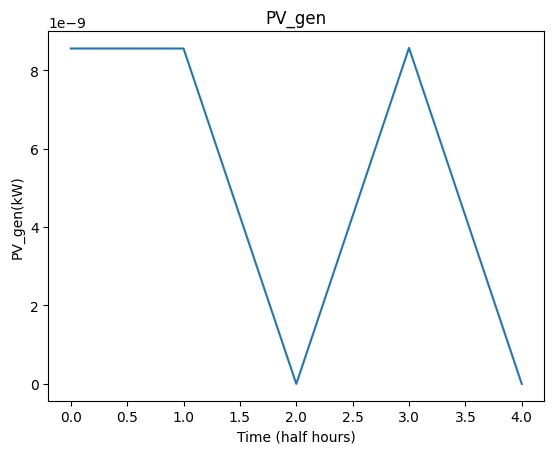

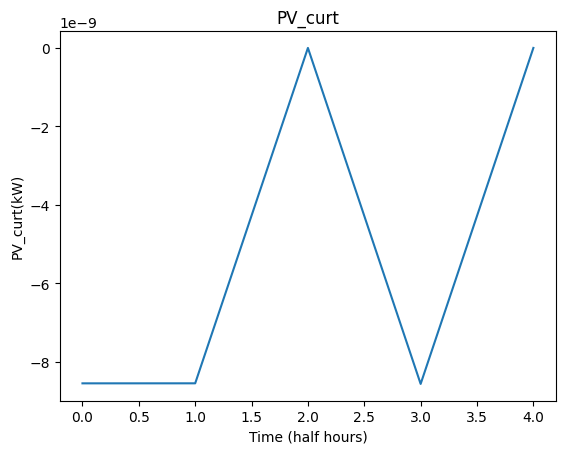

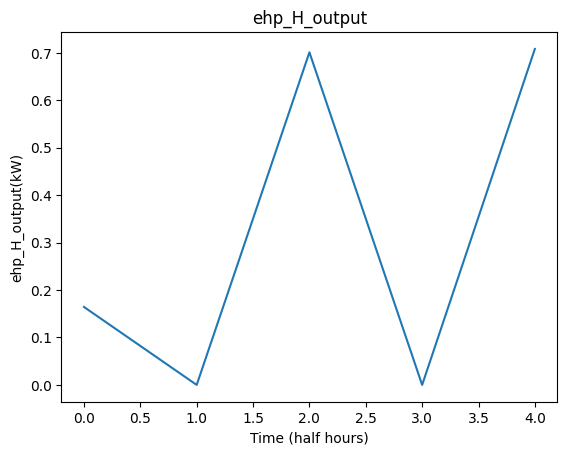

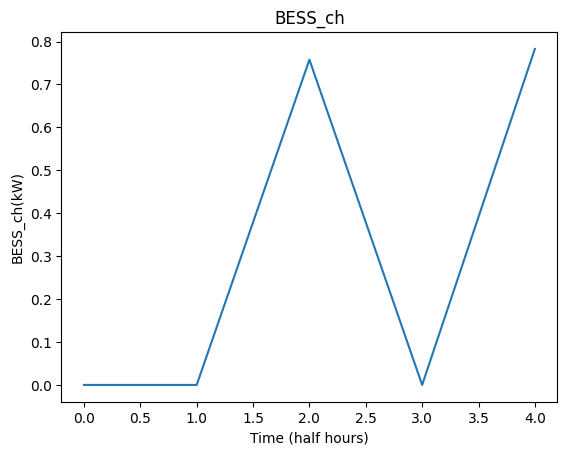

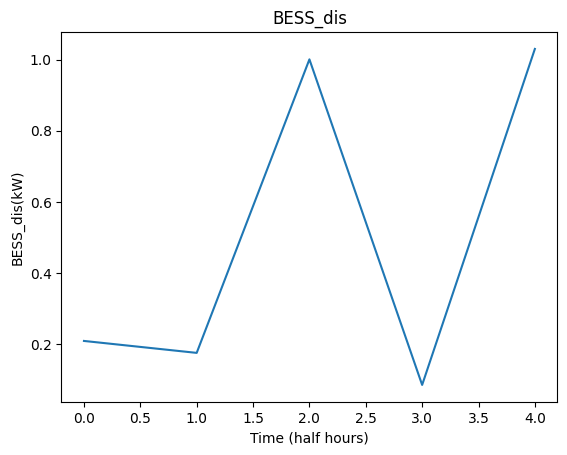

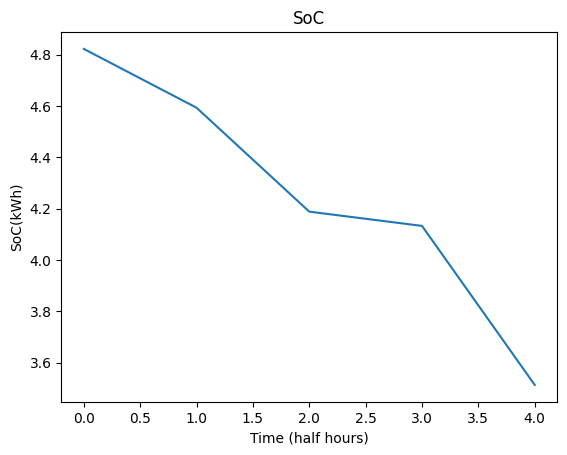

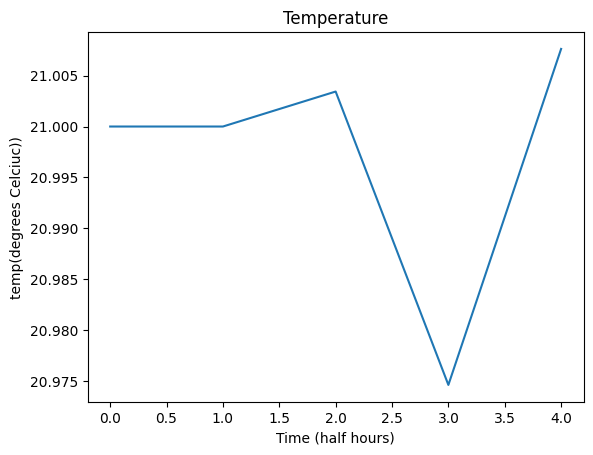

In [133]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/solar_temp_austin/solar_temp.csv', sep=",")
df['datetime'] = df['UTC_DATE'].astype(str) + df['UTC_TIME'].astype(str).str.zfill(4)
# convert the combined column to datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d%H%M')
# set the datetime column as the index
df.set_index('datetime', inplace=True)
# drop the 'UTC_DATE' and 'UTC_TIME' columns
df = df.drop(['UTC_DATE', 'UTC_TIME', 'WABANNO', 'LST_DATE', 'CRX_VN', 'LONG', 'LAT'], axis=1)
Ins_PV_set = df['SOLAR_RAD'][11:-1:6]
T_out_set = df['SURFACE_TEMP'][11:-1:6]

#read load
df = pd.read_csv('data/load_data/Electricity_Profile.csv', sep=",", header=None)
df = df.rename(columns={0: 'load'})
df['time'] = df.index%2400
freq_minutes = 1
n_rows = len(df)
date_col = pd.date_range(start='2023-01-01', periods=n_rows, freq=f'{freq_minutes}min')
df['datetime'] = date_col
df.set_index('datetime', inplace=True)
Load_set = df['load'][60:-1:30]

#set export and import tarrifs
Im_tariff = 4
Ex_tariff = 3

#optimise
PV_gen = []
PV_curt = []
ehp_E_input = []
ehp_H_output = []
BESS_ch = []
BESS_dis = []
BESS_net = []
SoC = []
temp = []
h_sh = []
P_in = []
P_out = []


for i in range(0,5):
    T_out = T_out_set[i : i+48]
    Ins_PV = Ins_PV_set[i : i+48]
    Load = Load_set[i : i+48]

    m = controller
    output = m.controller_model(controller,T_out, Load, Ins_PV, Im_tariff, Ex_tariff)

    PV_gen.append(pyo.value(output.PV_gen[i+1]))
    PV_curt.append(pyo.value(output.PV_curt[i+1]))
    ehp_E_input.append(pyo.value(output.ehp_E_input[i+1]))
    ehp_H_output.append(pyo.value(output.ehp_H_output[i+1]))
    BESS_ch.append(pyo.value(output.BESS_ch[i+1]))
    BESS_dis.append(pyo.value(output.BESS_dis[i+1]))
    SoC.append(pyo.value(output.SoC[i+1]))
    temp.append(pyo.value(output.temp[i+1]))
    h_sh.append(pyo.value(output.h_sh[i+1]))
    P_in.append(pyo.value(output.P_in[i+1]))
    P_out.append(pyo.value(output.P_out[i+1]))

plt.plot(range(0,5), PV_gen)
plt.xlabel('Time (half hours)')
plt.ylabel('PV_gen(kW)')
plt.title('PV_gen')
plt.figure()
plt.plot(range(0,5), PV_curt)
plt.xlabel('Time (half hours)')
plt.ylabel('PV_curt(kW)')
plt.title('PV_curt')
plt.figure()
plt.plot(range(0,5), ehp_H_output)
plt.xlabel('Time (half hours)')
plt.ylabel('ehp_H_output(kW)')
plt.title('ehp_H_output')
plt.figure()
plt.plot(range(0,5), BESS_ch)
plt.xlabel('Time (half hours)')
plt.ylabel('BESS_ch(kW)')
plt.title('BESS_ch')
plt.figure()
plt.plot(range(0,5), BESS_dis)
plt.xlabel('Time (half hours)')
plt.ylabel('BESS_dis(kW)')
plt.title('BESS_dis')
plt.figure()
plt.plot(range(0,5), SoC)
plt.xlabel('Time (half hours)')
plt.ylabel('SoC(kWh)')
plt.title('SoC')
plt.figure()
plt.plot(range(0,5), temp)
plt.xlabel('Time (half hours)')
plt.ylabel('temp(degrees Celciuc))')
plt.title('Temperature')




In [131]:
print(type(output.PV_gen))
print(pyo.value(output.PV_gen[1]))


<class 'pyomo.core.base.var.IndexedVar'>
4.821130266101508e-16
